# Template for tabular data
source data: Sp500

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pprint
import warnings
os.chdir('../')
print(os.getcwd())

C:\XW_projects\generic_template


In [2]:
data = pd.read_csv('data/sp500.csv', parse_dates=['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3624 entries, 0 to 3623
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3624 non-null   datetime64[ns]
 1   Open       3624 non-null   float64       
 2   High       3624 non-null   float64       
 3   Low        3624 non-null   float64       
 4   Close      3624 non-null   float64       
 5   Adj Close  3624 non-null   float64       
 6   Volume     3624 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 198.3 KB


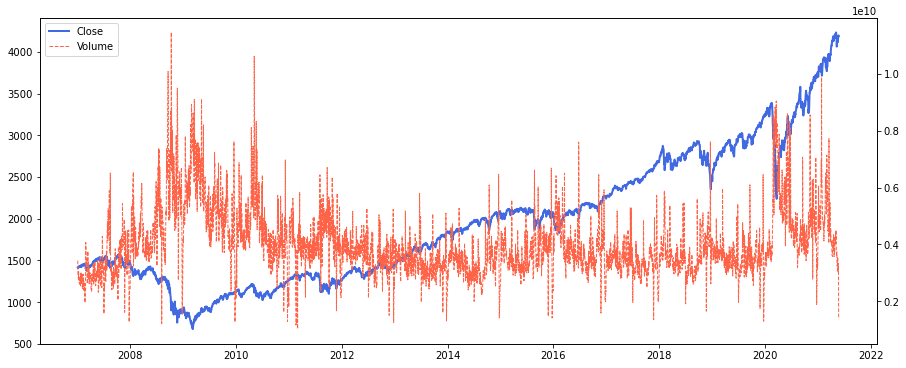

In [3]:
# double Y
fig, ax_close = plt.subplots(figsize=(15, 6))
ax_volume = ax_close.twinx()
ax_close.plot(data['Date'], data['Close'], color='royalblue', lw=2, label='Close')
ax_volume.plot(data['Date'], data['Volume'], color='tomato', lw=1, ls='dashed', label='Volume')
handles_close, labels_close = ax_close.get_legend_handles_labels()
handles_volume, labels_volume = ax_volume.get_legend_handles_labels()
ax_close.legend(handles_close + handles_volume, labels_close + labels_volume)


In [14]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


data_prophet = data.rename(columns={'Date': 'ds', 'Close': 'y'})[['ds', 'y']]

In [5]:
model = Prophet(growth='linear', daily_seasonality=False)
model.add_country_holidays(country_name='US')
model.fit(data_prophet)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

In [7]:
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
3984 2022-05-21  4121.002004  3875.274765  4339.611454  3945.191296   
3985 2022-05-22  4122.099014  3873.304749  4376.436534  3945.153411   
3986 2022-05-23  4123.196024  3912.486889  4389.633268  3945.323211   
3987 2022-05-24  4124.293034  3909.174055  4383.404142  3945.537369   
3988 2022-05-25  4125.390045  3911.713202  4370.776663  3945.751527   

      trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
3984  4281.839793            0.0                  0.0                  0.0   
3985  4283.869938            0.0                  0.0                  0.0   
3986  4285.821373            0.0                  0.0                  0.0   
3987  4288.686449            0.0                  0.0                  0.0   
3988  4290.516314            0.0                  0.0                  0.0   

      Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
3984                       0.0  ... -18.645596    -18.645596    -18.645596   
3985                       0.0  ... -18.645596    -18.645596    -18.645596   
3986                       0.0  ...   6.592143      6.592143      6.592143   
3987                       0.0  ...   8.803380      8.803380      8.803380   
3988                       0.0  ...   7.000530      7.000530      7.000530   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
3984  13.194488     13.194488     13.194488                   0.0   
3985  12.082687     12.082687     12.082687                   0.0   
3986  11.063456     11.063456     11.063456                   0.0   
3987  10.141608     10.141608     10.141608                   0.0   
3988   9.319214      9.319214      9.319214                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper         yhat  
3984                         0.0                         0.0  4115.550896  
3985                         0.0                         0.0  4115.536104  
3986                         0.0                         0.0  4140.851623  
3987                         0.0                         0.0  4143.238022  
3988                         0.0                         0.0  4141.709789  

[5 rows x 64 columns]

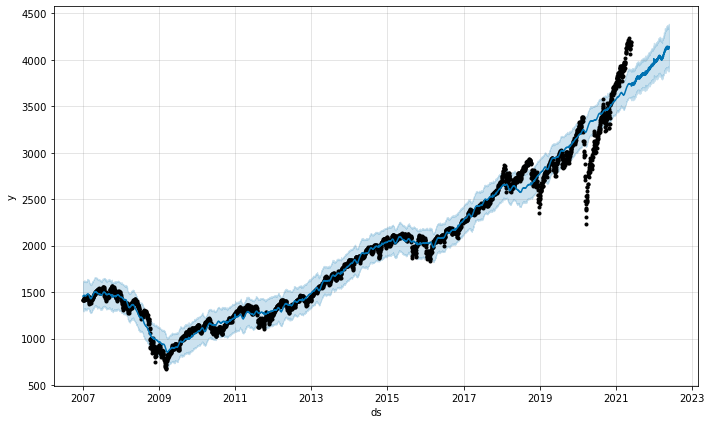

In [12]:
_ = model.plot(forecast)

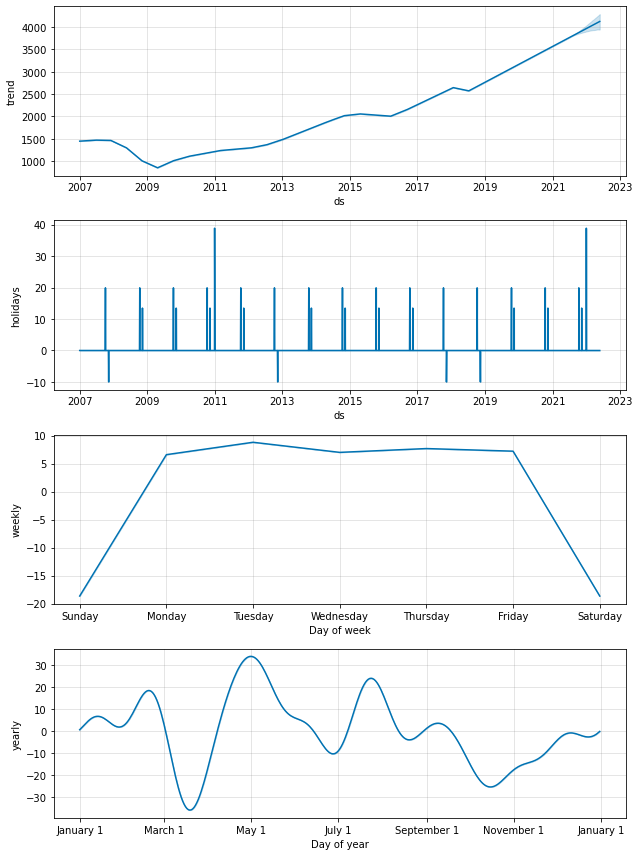

In [13]:
_ = model.plot_components(forecast)


In [15]:
plot_plotly(model, forecast)

In [16]:
plot_components_plotly(model, forecast)


In [6]:
import os
import optuna
from prophet import Prophet
from functools import partial
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
class suppress_stdout_stderr(object):
    """
    A context manager for doing a 'deep suppression' of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self._opt_loss = np.inf  # the smaller, the better!!!
        self._consecutive_no_improve_count = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if study.best_trial.value < self._opt_loss:
            self._opt_loss = study.best_trial.value
            self._consecutive_no_improve_count = 0
        else:
            self._consecutive_no_improve_count += 1

        if self._consecutive_no_improve_count >= self.patience:
            print(f'There is no improvement after {self.patience} trials. '
                  f'Stop the parameter optimization with opt loss = {self._opt_loss:.4e}.')
            study.stop()


In [ ]:
def cross_validate(data, n_splits=3, params=None):
    params = {} if params is None else params
    tscv = TimeSeriesSplit(n_splits=n_splits)
    losses = []
    for index_train, index_valid in tscv.split(data):
        model = init_model(params)
        data_train, data_valid = data.loc[index_train], data.loc[index_valid]
        with suppress_stdout_stderr():
            model.fit(data_train)
        data_pred = model.predict(data_valid.drop('y', axis=1))

        loss = mean_squared_error(y_true=data_valid['y'], y_pred=data_pred['yhat'], squared=False)
        losses.append(loss)
    loss_mean, loss_std = np.mean(losses), np.std(losses)
    print(f'Ave loss = {loss_mean:.4e} +- {loss_std:.4e}')
    return loss_mean


def suggest_params(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5),
        'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10),
        'holidays_prior_scale': trial.suggest_loguniform('holidays_prior_scale', 0.01, 10),
        'seasonality_mode': trial.suggest_categorical(
            'seasonality_mode', ['additive', 'multiplicative']
        ),
        'changepoint_range': trial.suggest_uniform('changepoint_range', 0.8, 0.95),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 10, 15),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 3, 6)
    }
    return params


def init_model(params: dict):
    model = Prophet(growth='linear', daily_seasonality=False, **params)
    model.add_country_holidays(country_name='US')
    return model


def objective(trial, data, n_splits):
    params = suggest_params(trial=trial)
    loss = cross_validate(data, n_splits=n_splits, params=params)
    return loss

In [ ]:
data_prophet = data.rename(columns={'Date': 'ds', 'Close': 'y'})[['ds', 'y']]
data_train, data_test = train_test_split(data_prophet, test_size=0.1, random_state=23,
                                         shuffle=False)
early_stopping = EarlyStoppingCallback(patience=10)
sampler = optuna.samplers.TPESampler(seed=23)
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='min_rmse')
study.optimize(partial(objective, data=data_train, n_splits=3), n_trials=100, callbacks=[early_stopping])
best_params = study.best_trial.params
best_loss = study.best_trial.value